In [1]:
import pandas as pd
import json


In [2]:
# Mapeamento dos valores qualitativos para valores numéricos
score_map = {
    "Muito ruim": 1,
    "Ruim": 2,
    "Regular": 3,
    "Bom": 4,
    "Muito bom": 5
}

# Carregar o arquivo CSV
data = pd.read_csv("judges_evaluation.csv")

In [3]:


# Função para processar cada linha
def process_judge_evaluation(row):
    debate_id = row['Número do Debate']
    evaluator = row['avaliador']

    debaters = []
    for i in range(1, 6):
        # Verificar se o debatedor existe
        if i == 4 and row.get('debater4_exists') == "Não":
            continue
        if i == 5 and row.get('debater5_exists') == "Não":
            continue

        # Coletar as métricas do debatedor
        debater_data = {
            "name": f"Debatedor {i}",
            "evaluation_aspects": {
                "organization_and_clarity": score_map.get(row.get(f"Organização e clareza  - Debatedor {i}"), 0),
                "use_of_examples": score_map.get(row.get(f"Uso de exemplos  - Debatedor {i}"), 0),
                "argumentation": score_map.get(row.get(f"Argumentação  - Debatedor {i}"), 0),
                "coherence": score_map.get(row.get(f"Coerência  - Debatedor {i}"), 0),
                "persuasion": score_map.get(row.get(f"Persuasão  - Debatedor {i}"), 0),
                "engagement": score_map.get(row.get(f"Engajamento  - Debatedor {i}"), 0),
                "adaptability": score_map.get(row.get(f"Adaptabilidade - Debatedor {i}"), 0),
                "preparation": score_map.get(row.get(f"Preparação  - Debatedor {i}"), 0),
                "subject_mastery": score_map.get(row.get(f"Domínio do tema - Debatedor {i}"), 0)
            }
        }
        debaters.append(debater_data)

    # Processar o hard voting
    best_debaters = [f"Debatedor {x.strip()}" for x in str(row['best_debater']).split(",") if x.strip().isdigit()]

    # Retornar o resultado como dicionário
    return {
        "debate_id": debate_id,
        "evaluator": evaluator,
        "debaters": debaters,
        "best_debaters": best_debaters,
        "justification": row.get("justification", "")
    }

# Processar todas as linhas do DataFrame
results = data.apply(process_judge_evaluation, axis=1)

# Salvar o JSON
output_path = "judge_evaluations.json"
with open(output_path, "w", encoding="utf-8") as outfile:
    json.dump(results.tolist(), outfile, indent=4, ensure_ascii=False)

print(f"Resultados salvos em {output_path}")


Resultados salvos em judge_evaluations.json


# GERANDO RANKINGS

In [6]:
from collections import defaultdict

def aggregate_judge_evaluations(input_file, output_file):
    with open(input_file, "r") as infile:
        evaluations = json.load(infile)

    aggregated_results = []
    debates = defaultdict(list)

    # Agrupar avaliações por debate_id
    for evaluation in evaluations:
        debates[evaluation["debate_id"]].append(evaluation)

    # Processar cada debate
    for debate_id, debate_evaluations in debates.items():
        debater_scores = defaultdict(lambda: {"soft_score": 0, "hard_votes": 0})

        # Somar as pontuações (soft voting) e contar votos (hard voting)
        for evaluation in debate_evaluations:
            for debater in evaluation["debaters"]:
                name = debater["name"]
                for aspect, score in debater["evaluation_aspects"].items():
                    debater_scores[name]["soft_score"] += score

            for best_debater in evaluation["best_debaters"]:
                debater_scores[best_debater]["hard_votes"] += 1

        # Gerar rankings para soft e hard voting
        def rank_debaters(scores_key):
            scores = [(name, data[scores_key]) for name, data in debater_scores.items()]
            scores.sort(key=lambda x: x[1], reverse=True)

            ranked = []
            current_position = 1
            for i, (name, score) in enumerate(scores):
                if i > 0 and score < scores[i - 1][1]:
                    current_position = i + 1
                ranked.append({"position": current_position, "name": name, "score": score})

            return ranked

        soft_ranking = rank_debaters("soft_score")
        hard_ranking = rank_debaters("hard_votes")

        aggregated_results.append({
            "debate_id": debate_id,
            "soft_voting_ranking": soft_ranking,
            "hard_voting_ranking": hard_ranking
        })

    # Salvar resultados agregados
    with open(output_file, "w") as outfile:
        json.dump(aggregated_results, outfile, indent=4)

# Arquivos de entrada e saída
input_file = "judge_evaluations.json"
output_file = "aggregated_debate_results.json"
aggregate_judge_evaluations(input_file, output_file)


## GERANDO WORDCLOUDS (WINNERS)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Klaywert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


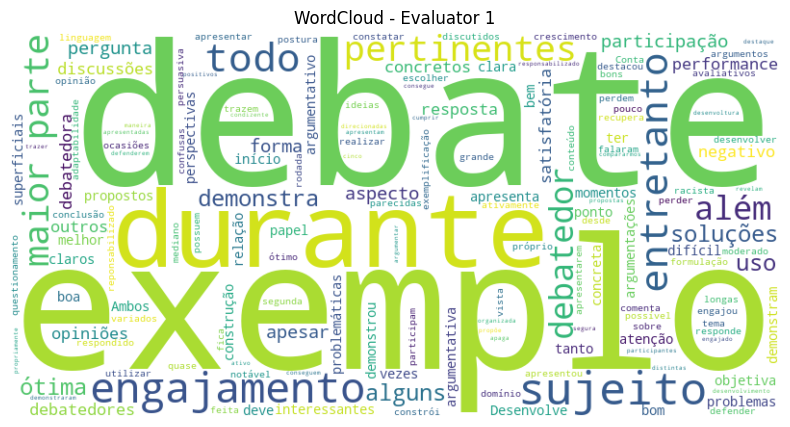

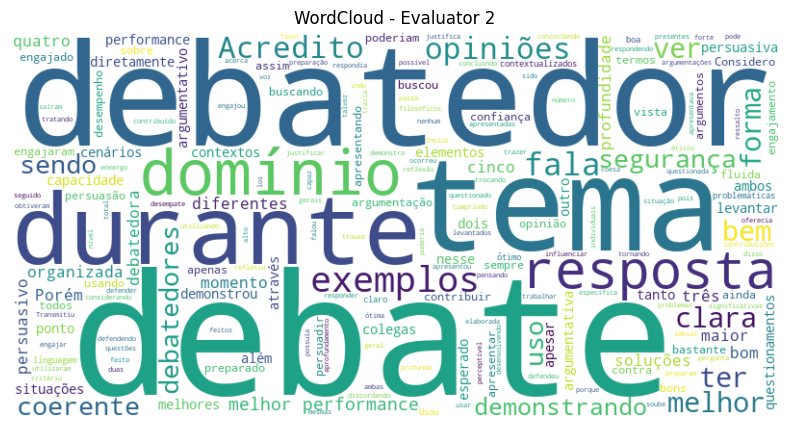

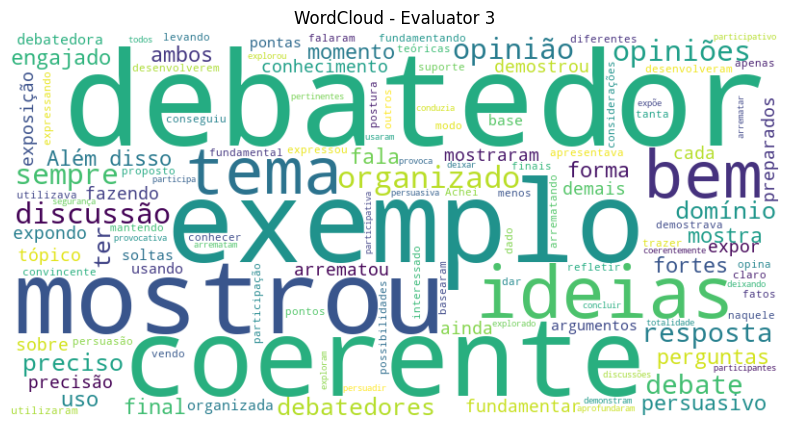

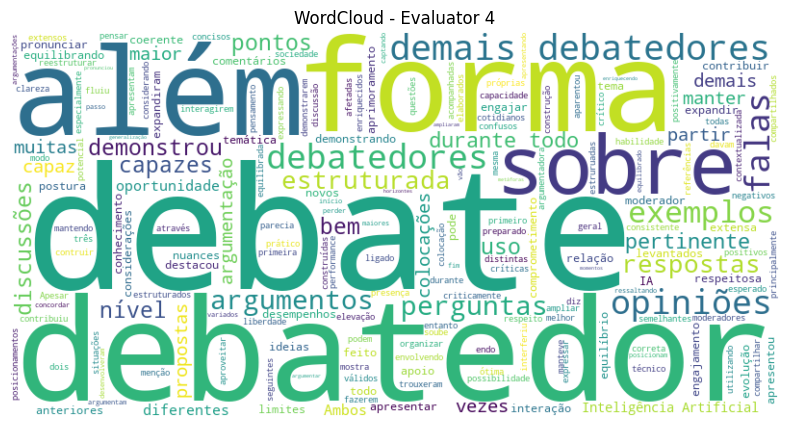

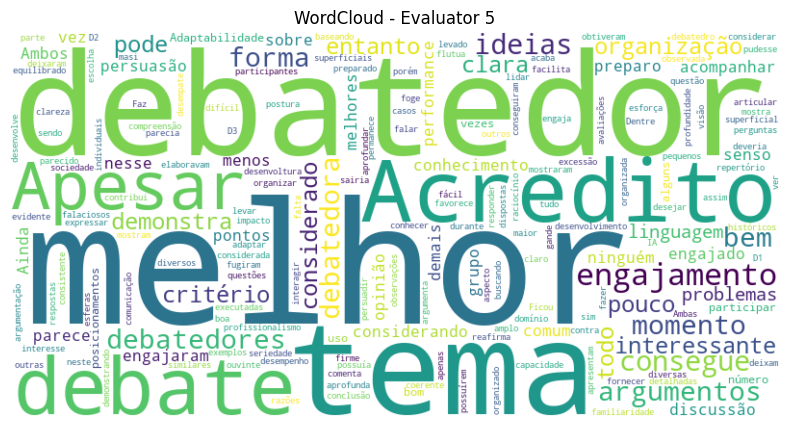

In [1]:
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import defaultdict
import nltk

# Baixar as stopwords em português
nltk.download('stopwords')
portuguese_stopwords = set(stopwords.words('portuguese'))

# Carregar o arquivo JSON
with open('judge_evaluations.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Agrupar justificativas por evaluator
justifications_by_evaluator = defaultdict(str)
for entry in data:
    evaluator = entry['evaluator']
    justification = entry.get('justification', "")
    justifications_by_evaluator[evaluator] += " " + justification

# Gerar as wordclouds para cada evaluator
for evaluator, text in justifications_by_evaluator.items():
    # Gerar a wordcloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=portuguese_stopwords,
        colormap='viridis'
    ).generate(text)
    
    # Plotar a wordcloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud - Evaluator {evaluator}')
    plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Klaywert\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


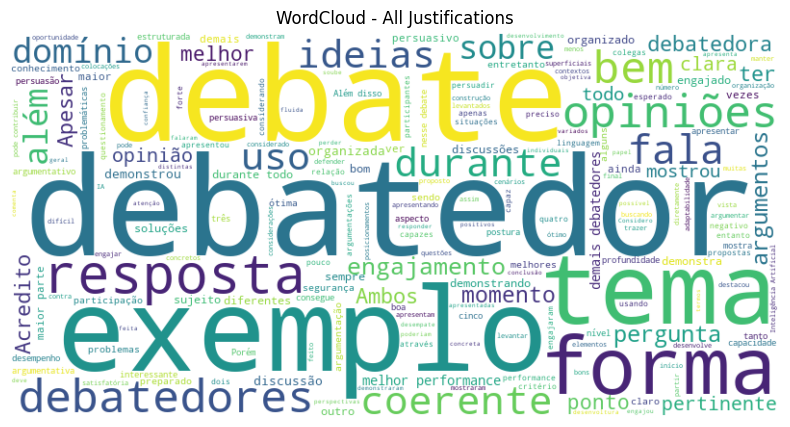

In [2]:
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk

# Baixar as stopwords em português
nltk.download('stopwords')
portuguese_stopwords = set(stopwords.words('portuguese'))

# Carregar o arquivo JSON
with open('judge_evaluations.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Combinar todas as justificativas
all_justifications = " ".join(entry.get('justification', "") for entry in data)

# Gerar a wordcloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=portuguese_stopwords,
    colormap='viridis'
).generate(all_justifications)

# Plotar a wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - All Justifications')
plt.show()
